In [1]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import copy
import random
import multiprocessing as mp
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Enable CUDA debugging, use to block cuda calls until completion
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = torch.device('cpu')  # Temporarily switch to CPU

In [4]:
# Load node datasets
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0) # Substrates
p_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/p_emb_full_237197.csv', index_col=0) # Proteins

In [5]:
# Load edge datasets (combined with negative samples)
ppi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ppi_edges_full.csv') # Protein-Protein Interactions
ssi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ssi_edges_full.csv') # Substrate-Substrate Interactions
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/distributed_combined_tp_s_edges_13340.csv',) # Transporter Protein-Substrate Interactions

In [6]:
# Inspect and clean the data, node dataframes should be numeric
def inspect_and_clean(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns: {non_numeric_columns}")
    if len(non_numeric_columns) > 0:
        df[non_numeric_columns] = df[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    return df

In [7]:
# Enumerate the proteins and substrates for mapping
def get_mapping(p_dataframe, s_dataframe):
    protein_mapping = {protein_id: i for i, protein_id in enumerate(p_dataframe.index)}
    substrate_mapping = {substrate_id: i for i, substrate_id in enumerate(s_dataframe.index)}
    return protein_mapping, substrate_mapping


In [8]:
# Map the edges to the enumerated proteins and substrates
def map_edges(edge_df, source_mapping, target_mapping, edge_type):
    edge_df = edge_df.copy()

    # Apply mapping
    edge_df['source'] = edge_df['source'].map(source_mapping)
    edge_df['target'] = edge_df['target'].map(target_mapping)

    # Drop rows with NaNs in mapped columns
    edge_df.dropna(subset=['source', 'target'], inplace=True)
      
    return edge_df


In [9]:
# Apply transformations in batches, this can be useful when dealing with large 
# datasets that may not fit into memory or GPU all at once. 
def transform_in_batches(features, transform_layer, batch_size=10000):
    num_samples = features.shape[0]
    print(f"Number of samples: {num_samples}")
    transformed_features = []
    for i in range(0, num_samples, batch_size):
        batch = features[i:i + batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float).to(device)
        transformed_batch = transform_layer(batch_tensor)
        transformed_features.append(transformed_batch.detach().cpu().numpy())  # Use detach() before numpy()
    return np.vstack(transformed_features) # Stack arrays in sequence vertically (row wise)


In [10]:
def split_train_val_data(df, train_size=0.9, val_size=0.1):
    # Split into train and validation (90% train, 10% validation)
    train_df, val_df = train_test_split(df, train_size=train_size, random_state=42)
    
    return train_df, val_df


In [11]:
# Create edge index tensors for training, validation, and test
def get_tensor(df):
    return torch.tensor(df[['source', 'target']].values.T, dtype=torch.long)


In [12]:
# Labels remain the same
def get_labels(df):
    return torch.tensor(df['label'].values, dtype=torch.float)


In [13]:
s_df = inspect_and_clean(s_df)
p_df = inspect_and_clean(p_df)


Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [14]:
protein_mapping, substrate_mapping = get_mapping(p_df, s_df)

In [15]:
# Apply the debugging function to map edges
mapped_ppi_edges_df = map_edges(ppi_df, protein_mapping, protein_mapping, 'PPI')
mapped_ssi_edges_df = map_edges(ssi_df, substrate_mapping, substrate_mapping, 'SSI')
mapped_tp_s_df = map_edges(tp_s_df, protein_mapping, substrate_mapping, 'TP-S')

In [16]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71      33      0
4350      92      97      0
4351     140     145      0
4352      24     153      0
4353      86      81      0

[4354 rows x 3 columns]
       source  target  label
0      110150       0      1
1      113110       0      1
2       94944      63      1
3       86624      63      1
4      132714       0      1
...       ...     ...    ...
26675  118949      18  

In [17]:
# Convert features to numpy arrays
s_features = s_df.values
p_features = p_df.values

In [18]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (?, 1536)
print(f"p_features shape: {p_features.shape}")  # Expected (?, 2048)


s_features shape: (183, 1536)
p_features shape: (237197, 2048)


In [19]:
# Normalize features (normalizes columns to have mean 0 and variance 1)
s_features = (s_features - np.mean(s_features, axis=0)) / np.std(s_features, axis=0)
p_features = (p_features - np.mean(p_features, axis=0)) / np.std(p_features, axis=0)

In [20]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (?, 1536)
print(f"p_features shape: {p_features.shape}")  # Expected (?, 2048)


s_features shape: (183, 1536)
p_features shape: (237197, 2048)


In [21]:
# Define the transformation layers, changes the number of features 1536 -> 2048
# for substrates and 2048 -> 2048 for proteins. The transform_p layer is useful 
# for transforming the feature representation within the same dimensional space,
#  y = Wx + b.

transform_s = Linear(1536, 2048).to(device) # Change depending on the number of features
transform_p = Linear(2048, 2048).to(device)

In [22]:
# Perform the transformations in batches
s_features_transformed = transform_in_batches(s_features, transform_s)
p_features_transformed = transform_in_batches(p_features, transform_p)


Number of samples: 183
Number of samples: 237197


In [23]:
# Check shapes to ensure correct dimensions
print(f"s_features_transformed shape: {s_features_transformed.shape}")  # Expected (?, 2048)
print(f"p_features_transformed shape: {p_features_transformed.shape}")  # Expected (?, 2048)


s_features_transformed shape: (183, 2048)
p_features_transformed shape: (237197, 2048)


In [24]:
# Convert back to tensors
s_features_tensor = torch.tensor(s_features_transformed, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_features_transformed, dtype=torch.float).to(device)


In [25]:
# Combine features, vertically stacks features (dim=0) to create a single tensor
all_features = torch.cat([p_features_tensor, s_features_tensor], dim=0)


In [26]:
print(f"all_features shape: {all_features.shape}")  # Expected (?, 2048)

all_features shape: torch.Size([237380, 2048])


In [27]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71      33      0
4350      92      97      0
4351     140     145      0
4352      24     153      0
4353      86      81      0

[4354 rows x 3 columns]
       source  target  label
0      110150       0      1
1      113110       0      1
2       94944      63      1
3       86624      63      1
4      132714       0      1
...       ...     ...    ...
26675  118949      18  

In [28]:
# Filter for positive labels
positive_tp_s_df = mapped_tp_s_df[mapped_tp_s_df['label'] == 1]

# Calculate source node cardinality for positive labels
positive_source_cardinality = positive_tp_s_df['source'].value_counts().reset_index()
positive_source_cardinality.columns = ['source_node', 'count']
# positive_source_cardinality.head(50)


In [29]:
# Step 1: Filter tp_s_edges_df for positive labels
positive_tp_s_df = mapped_tp_s_df[mapped_tp_s_df['label'] == 1]

# Step 2: Calculate the source node cardinality from tp_s_edges_df
tp_s_source_cardinality = positive_tp_s_df['source'].value_counts().reset_index()
tp_s_source_cardinality.columns = ['source_node', 'tp_s_count']

# Step 3: Calculate the source node cardinality from ppi_edge_df
ppi_source_cardinality = mapped_ppi_edges_df['source'].value_counts().reset_index()
ppi_source_cardinality.columns = ['source_node', 'ppi_count']

# Step 4: Merge both cardinalities on source node, filling NaN values with 0
combined_cardinality = pd.merge(tp_s_source_cardinality, ppi_source_cardinality, on='source_node', how='left').fillna(0)

# Step 5: Sum the counts from both tp_s and ppi edges
combined_cardinality['total_count'] = combined_cardinality['tp_s_count'] + combined_cardinality['ppi_count']

# Optional: Drop individual counts if only total count is needed
# combined_cardinality = combined_cardinality[['source_node', 'total_count']]


In [30]:
import pandas as pd
import numpy as np

# Step 1: Set a seed for reproducibility
np.random.seed(42)

# Step 2: Randomly select 50 unique source nodes from the tp_s_df
random_source_nodes = np.random.choice(combined_cardinality.head(50)['source_node'].unique(), size=50, replace=False)

# Step 3: Filter the tp_s_df to only include rows with the selected source nodes
test_tp_s_df = mapped_tp_s_df[mapped_tp_s_df['source'].isin(random_source_nodes)]

# Check the result
print(test_tp_s_df)


       source  target  label
692      1269     135      1
693      1269     163      1
694      1269     134      1
695      1269      19      1
696      1269      90      1
...       ...     ...    ...
26356   39549      78      0
26369   14460       0      0
26455   16269     118      0
26535   30300      54      0
26642   11611      65      0

[555 rows x 3 columns]


In [31]:
# Assuming test_tp_s_df is already defined
test_tp_s_df = test_tp_s_df.drop_duplicates(subset='source')
test_tp_s_df

,source,target,label
692,1269,135,1
824,11941,11,1
1012,21228,57,1
1205,3285,71,1
1245,14460,2,1
1782,17165,8,1
2099,13664,48,1
2131,39549,149,1
2183,9891,11,1
2233,11611,57,1


In [32]:

# Assuming tp_s_df and test_tp_s_df are your DataFrames with a column named 'source'

# Step 1: Count the occurrences of each 'source' in tp_s_df
source_counts = mapped_tp_s_df.groupby('source').size().reset_index(name='count')

# Step 2: Filter the counts to include only those sources present in test_tp_s_df
test_sources = test_tp_s_df['source'].unique()
matching_source_counts = source_counts[source_counts['source'].isin(test_sources)]

# Step 3: Calculate the total count of occurrences for the matching sources
total_count = matching_source_counts['count'].sum()

# matching_source_counts now contains the count of occurrences for each 'source' in test_tp_s_df
# total_count contains the sum of all these counts

# Display the results
print("Individual counts:")
print(matching_source_counts)

print("\nTotal count of occurrences:")
print(total_count)


Individual counts:
     source  count
18      678     11
36     1269     11
42     1483      7
51     1681      8
67     2800      8
75     3285      9
175    8325     10
233    9870     11
234    9891     10
277   11611     10
283   11941      8
310   13664     11
325   14460      9
332   14899      9
340   15133     12
359   16269     12
378   17165     17
379   17171     14
380   17189      9
438   19992     10
451   21228     13
453   21389     10
478   24065     20
500   25184     12
503   25252      8
508   25409      9
533   26410      9
537   26569     17
578   28510      8
581   28544     19
599   29464     10
603   30300     12
607   30473      9
610   30966      9
611   30982     10
621   31722     11
637   32693     23
639   32872     12
644   33242     12
650   33515      9
651   33770      8
673   35189     11
683   35611      7
705   37184     11
719   39277     17
730   39549      9
751   41187     17
773   42487     11
806   44883      7
857   47909      9

Total count

In [33]:
# REMOVE ROWS FROM tp_s_df AND SAVES TO train_tp_s_df
# Assuming tp_s_df and test_tp_s_df are your DataFrames with a column named 'source'

# Extract the unique 'source' values from test_tp_s_df
test_sources = test_tp_s_df['source'].unique()

# Filter tp_s_df to remove rows where 'source' matches any 'source' in test_tp_s_df
train_tp_s_df = mapped_tp_s_df[~mapped_tp_s_df['source'].isin(test_sources)]

# Reset index if needed
train_tp_s_df.reset_index(drop=True, inplace=True)

# filtered_tp_s_df now contains the modified DataFrame with the matching 'source' rows removed
train_tp_s_df

,source,target,label
0,110150,0,1
1,113110,0,1
2,94944,63,1
3,86624,63,1
4,132714,0,1
...,...,...,...
26120,118949,18,0
26121,87873,0,0
26122,88009,19,0
26123,97381,63,0


### Add back number of edges

In [34]:
# Parameters
n = 15  # Number of edges to add back per source

# Step 1: Extract the unique 'source' values from test_tp_s_df
test_sources = test_tp_s_df['source'].unique()

# Step 2: Filter tp_s_df to remove rows where 'source' matches any 'source' in test_tp_s_df
removed_edges_df = mapped_tp_s_df[mapped_tp_s_df['source'].isin(test_sources)]
train_tp_s_df = mapped_tp_s_df[~mapped_tp_s_df['source'].isin(test_sources)]

# Exclude edges that are in test_tp_s_df
excluded_edges = test_tp_s_df[['source', 'target']]

# Step 3: For each source, add back n edges (or as many as exist, up to n)
edges_to_add_back = pd.DataFrame()

for source in test_sources:
    # Find the edges related to this source in the removed_edges_df
    source_edges = removed_edges_df[removed_edges_df['source'] == source]
    
    # Exclude edges that are part of the test set
    source_edges = source_edges.merge(excluded_edges, on=['source', 'target'], how='left', indicator=True)
    source_edges = source_edges[source_edges['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # Randomly select up to n edges to add back
    edges_to_add = source_edges.sample(n=min(n, len(source_edges)), random_state=42)
    
    # Append the selected edges to the edges_to_add_back DataFrame
    edges_to_add_back = pd.concat([edges_to_add_back, edges_to_add])

# Step 4: Add the selected edges back to train_tp_s_df
train_tp_s_df = pd.concat([train_tp_s_df, edges_to_add_back])

# Reset index if needed
train_tp_s_df.reset_index(drop=True, inplace=True)

# Now, train_tp_s_df contains the remaining edges plus up to n edges for each removed source, excluding those in test_tp_s_df
print(f"Final train_tp_s_df size: {train_tp_s_df.shape[0]}")


Final train_tp_s_df size: 26612


In [35]:
# Split data for each edge type (without test, as test is predefined)
ppi_train_df, ppi_val_df = split_train_val_data(mapped_ppi_edges_df)
ssi_train_df, ssi_val_df = split_train_val_data(mapped_ssi_edges_df)
tp_s_train_df, tp_s_val_df = split_train_val_data(train_tp_s_df)


In [36]:
positive_tp_s_train_df = tp_s_train_df[tp_s_train_df['label'] == 1]

train_edges_tp_s_positive = torch.tensor(positive_tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ppi_train_df = ppi_train_df[ppi_train_df['label'] == 1]

train_edges_ppi_positive = torch.tensor(positive_ppi_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ssi_train_df = ssi_train_df[ssi_train_df['label'] == 1]

train_edges_ssi_positive = torch.tensor(positive_ssi_train_df[['source', 'target']].values.T, dtype=torch.long)

In [37]:
# Create edge index tensors for training, validation, and test
train_edges_tp_s = torch.tensor(tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_tp_s = torch.tensor(tp_s_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_tp_s = torch.tensor(test_tp_s_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ppi = torch.tensor(ppi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ppi = torch.tensor(ppi_val_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ssi = torch.tensor(ssi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ssi = torch.tensor(ssi_val_df[['source', 'target']].values.T, dtype=torch.long)
# Labels remain the same
train_labels_tp_s = torch.tensor(tp_s_train_df['label'].values, dtype=torch.float)
val_labels_tp_s = torch.tensor(tp_s_val_df['label'].values, dtype=torch.float)
test_labels_tp_s = torch.tensor(test_tp_s_df['label'].values, dtype=torch.float)

train_labels_ppi = torch.tensor(ppi_train_df['label'].values, dtype=torch.float)
val_labels_ppi = torch.tensor(ppi_val_df['label'].values, dtype=torch.float)

train_labels_ssi = torch.tensor(ssi_train_df['label'].values, dtype=torch.float)
val_labels_ssi = torch.tensor(ssi_val_df['label'].values, dtype=torch.float)


In [38]:
print(f"Positive TP-S edges: {train_edges_tp_s_positive.shape}")
print(f"Positive PPI edges: {train_edges_ppi_positive.shape}")
print(f"Positive SSI edges: {train_edges_ssi_positive.shape}")


Positive TP-S edges: torch.Size([2, 11944])
Positive PPI edges: torch.Size([2, 5996375])
Positive SSI edges: torch.Size([2, 1946])


In [39]:
data = HeteroData()

# Assign node features
data['protein'].x = p_features_tensor
data['substrate'].x = s_features_tensor

# Assign training edges
data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s_positive 
data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi_positive
data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi_positive

# # Assign training edges
# data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s 
# data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi 
# data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi 


In [40]:
print(f"Number of edges: {train_edges_tp_s.shape[1]}")
print(f"Number of labels: {train_labels_tp_s.shape[0]}")


Number of edges: 23950
Number of labels: 23950


Epoch 1, Train Loss: 0.6932, Validation Loss: 0.6878, Val Accuracy: 0.5545, Precision: 0.5817, Recall: 0.3997, F1: 0.4738, AUC: 0.5811, LR: 0.0001
Epoch 2, Train Loss: 0.6881, Validation Loss: 0.6827, Val Accuracy: 0.5687, Precision: 0.5783, Recall: 0.5195, F1: 0.5473, AUC: 0.6263, LR: 0.0001
Epoch 3, Train Loss: 0.6835, Validation Loss: 0.6780, Val Accuracy: 0.6041, Precision: 0.6000, Recall: 0.6332, F1: 0.6162, AUC: 0.6654, LR: 0.0001
Epoch 4, Train Loss: 0.6792, Validation Loss: 0.6736, Val Accuracy: 0.6311, Precision: 0.6148, Recall: 0.7096, F1: 0.6588, AUC: 0.6979, LR: 0.0001
Epoch 5, Train Loss: 0.6751, Validation Loss: 0.6692, Val Accuracy: 0.6450, Precision: 0.6244, Recall: 0.7343, F1: 0.6749, AUC: 0.7243, LR: 0.0001
Epoch 6, Train Loss: 0.6709, Validation Loss: 0.6647, Val Accuracy: 0.6566, Precision: 0.6339, Recall: 0.7478, F1: 0.6861, AUC: 0.7446, LR: 0.0001
Epoch 7, Train Loss: 0.6665, Validation Loss: 0.6600, Val Accuracy: 0.6668, Precision: 0.6436, Recall: 0.7530, F1: 0.6

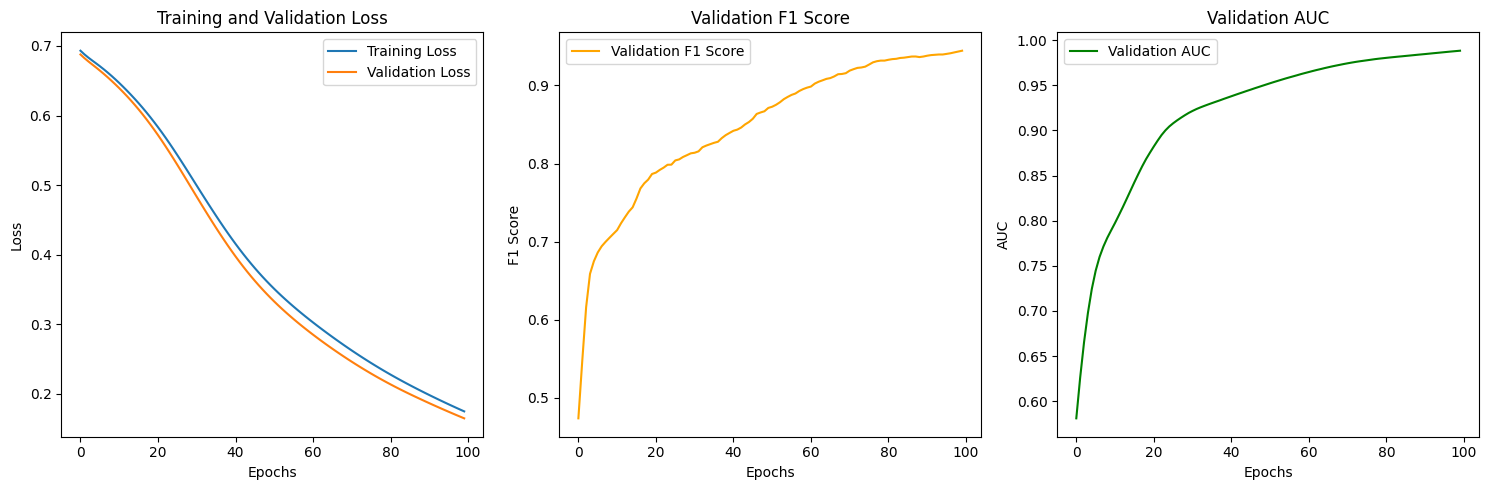

In [41]:
import matplotlib.pyplot as plt

# Define the model
class GCNLinkPredictor(nn.Module):
    def __init__(self, protein_dim, substrate_dim, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.protein_conv1 = GCNConv(protein_dim, hidden_channels)
        self.substrate_conv1 = GCNConv(substrate_dim, hidden_channels)
        self.protein_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.substrate_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.projection_layer = Linear(hidden_channels * 2, 128)
        self.link_predictor = nn.Sequential(
            nn.Linear(128, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def encode(self, x_dict, edge_index_dict):
        # Use ppi edges to update protein embeddings
        if ('protein', 'interacts_with', 'protein') in edge_index_dict:
            z_protein = self.protein_conv1(x_dict['protein'], edge_index_dict[('protein', 'interacts_with', 'protein')])
            z_protein = self.protein_conv2(z_protein, edge_index_dict[('protein', 'interacts_with', 'protein')])
        else:
            z_protein = x_dict['protein']

        # Use ssi edges to update substrate embeddings
        if ('substrate', 'interacts_with', 'substrate') in edge_index_dict:
            z_substrate = self.substrate_conv1(x_dict['substrate'], edge_index_dict[('substrate', 'interacts_with', 'substrate')])
            z_substrate = self.substrate_conv2(z_substrate, edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        else:
            z_substrate = x_dict['substrate']

        # Use tp_s edges to update embeddings
        if ('protein', 'interacts_with', 'substrate') in edge_index_dict:
            edge_indices = edge_index_dict[('protein', 'interacts_with', 'substrate')]
            protein_indices = edge_indices[0]
            substrate_indices = edge_indices[1]

            z_protein_tp_s = self.protein_conv1(x_dict['protein'], torch.stack([protein_indices, protein_indices], dim=0))
            z_substrate_tp_s = self.substrate_conv1(x_dict['substrate'], torch.stack([substrate_indices, substrate_indices], dim=0))

            z_protein += z_protein_tp_s
            z_substrate += z_substrate_tp_s

        return z_protein, z_substrate

    def forward(self, x_dict, edge_index_dict, edges):
        # Encoding step
        z_protein, z_substrate = self.encode(x_dict, edge_index_dict)

        # Concatenate the protein and substrate embeddings along the feature dimension
        z_combined = torch.cat([z_protein[edges[0]], z_substrate[edges[1]]], dim=-1)
        
        z_projected = self.projection_layer(z_combined)
        
        # Return the predictions
        return self.link_predictor(z_projected).squeeze()


# Initialize the model
model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

# Train function
def train(data, train_edges_tp_s_positive, train_labels_tp_s_positive):
    model.train()

    optimizer.zero_grad()
    
    # Pass only positive edges to the model
    out = model(data.x_dict, data.edge_index_dict, train_edges_tp_s_positive)
    
    # Ensure the loss is calculated using the correct labels
    loss = criterion(out, train_labels_tp_s_positive)
    loss.backward()
    optimizer.step()
    
    return loss.item(), out.detach()


# Validate function
def validate(data, val_edges_tp_s, val_labels_tp_s):
    model.eval()
    with torch.no_grad():
        # Forward pass using all edges
        out = model(data.x_dict, data.edge_index_dict, val_edges_tp_s)
        # Loss calculated only on tp_s edges
        loss = criterion(out, val_labels_tp_s)
    return loss.item(), out

# Test function
def test(data, test_edges_tp_s, test_labels_tp_s):
    model.eval()
    with torch.no_grad():
        # Replace tp_s edges in HeteroData for testing
        data['protein', 'interacts_with', 'substrate'].edge_index = test_edges_tp_s
        out = model(data.x_dict, data.edge_index_dict, test_edges_tp_s)
        # Loss and metrics calculated only on tp_s edges
        loss = criterion(out, test_labels_tp_s)
        accuracy, precision, recall, f1, auc = calculate_metrics(test_labels_tp_s, out)
    return loss.item(), accuracy, precision, recall, f1, auc

# Calculate additional metrics
def calculate_metrics(labels, preds):
    preds = torch.sigmoid(preds).cpu().numpy()
    preds_binary = (preds > 0.5).astype(int)
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds_binary)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)
    
    # Handle the case where only one class is present in y_true
    if len(np.unique(labels)) > 1:
        auc = roc_auc_score(labels, preds)
    else:
        auc = None  # AUC is not defined when only one class is present

    return accuracy, precision, recall, f1, auc


# Training loop
train_losses = []
val_losses = []
val_f1 = []
val_auc = []
epochs = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10

for epoch in range(epochs):
    train_loss, train_preds = train(data, train_edges_tp_s, train_labels_tp_s)
    val_loss, val_preds = validate(data, val_edges_tp_s, val_labels_tp_s)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy, precision, recall, f1, auc = calculate_metrics(val_labels_tp_s, val_preds)
    val_f1.append(f1)
    if auc is not None:
        val_auc.append(auc)
    else:
        val_auc.append(0)  # Handle the case where AUC is not applicable

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, AUC: {auc:.4f}, LR: {scheduler.get_last_lr()[0]}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), '/data/servilla/DT_HGNN/data/Models_saves/best_model_iso_20240904_15.pth')
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plotting Training Loss, Validation Loss, F1 Score, and AUC
plt.figure(figsize=(15, 5))

# Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Validation F1 Score
plt.subplot(1, 3, 2)
plt.plot(val_f1, label='Validation F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

# Validation AUC
plt.subplot(1, 3, 3)
plt.plot(val_auc, label='Validation AUC', color='green')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
# Load the best model
model.load_state_dict(torch.load('/data/servilla/DT_HGNN/data/Models_saves/best_model_iso_20240904_15.pth'))
model.eval()  # Set the model to evaluation mode


GCNLinkPredictor(
  (protein_conv1): GCNConv(2048, 64)
  (substrate_conv1): GCNConv(2048, 64)
  (protein_conv2): GCNConv(64, 64)
  (substrate_conv2): GCNConv(64, 64)
  (projection_layer): Linear(in_features=128, out_features=128, bias=True)
  (link_predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [43]:
def test(data, test_edges_tp_s, test_labels_tp_s):
    model.eval()
    with torch.no_grad():
        # Replace the tp_s edges in HeteroData for testing
        data['protein', 'interacts_with', 'substrate'].edge_index = test_edges_tp_s
        
        # Forward pass: Generate predictions using the test edges
        out = model(data.x_dict, data.edge_index_dict, test_edges_tp_s)
        
        # Calculate loss and metrics based only on tp_s edges
        loss = criterion(out, test_labels_tp_s)
        accuracy, precision, recall, f1, auc = calculate_metrics(test_labels_tp_s, out)
    
    return loss.item(), accuracy, precision, recall, f1, auc

# Example of running the test
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_auc = test(data, test_edges_tp_s, test_labels_tp_s)

# Handle AUC in the print statement
if test_auc is not None:
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, "
          f"F1: {test_f1:.4f}, AUC: {test_auc:.4f}")
else:
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, "
          f"F1: {test_f1:.4f}, AUC: Not applicable (only one class present)")


Test Loss: 0.5234, Test Accuracy: 0.7800, Precision: 1.0000, Recall: 0.7800, F1: 0.8764, AUC: Not applicable (only one class present)


### Stop Here!